# Execution example of SpinSVAR

In [1]:
import numpy as np
import time
import torch

import matplotlib.pyplot as plt


###################### SpinSVAR
import experiments
from experiments.evaluation.evaluation import input_approximation
from experiments.data import data_generation
from experiments.plot_experiment import visualize
from experiments.methods.utils import execute_R
from experiments import utils
from sparserc.sparserc import sparserc_solver
from sparserc.spinsvar import spinsvar_solver

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nUsing device: {}\n'.format(device))
    


Using device: cpu



## Data generation via a linear SEM with few root causes

In [2]:
# first we define the experimental setup

# random graph parameters
T = 1000 # total number of timesteps 
d = 20 # number of nodes of the graph
number_of_lags = 2 # data at time t are at mostly dependent from data at time t - number_of_lags
algo_lags = 2
p = number_of_lags # same
k = 5 # equal to average degree of the graph
graph_type = "ER" # Erdös-Renyi graphs
(a, b) = (0.1, 0.5) # bounds for the weights of the adjacency matrix
# => the graph will be transformed into a DAG by assigning a random order

# Data on the graph parameters
N = 10 # number of data samples = number of individual time-sequences 
fixSup = 'False' # support of the root causes is varying
sparsity =  0.05
sparsity_type = "uniform" # what weights to assign on the non-zero inputs

noise_type = 'gauss'
noise_std = 0.01

# Execution parameters
runs = 5 # how many times to repeat the experiment generating a new DAG and run the method each time
spinsvar_epochs = 10000 # for how many epochs we let SparseRCT run
omega = 0.09

# NTS-NOTEARS 
sem_type = 'AdditiveIndexModel'
w_threshold = 0.09

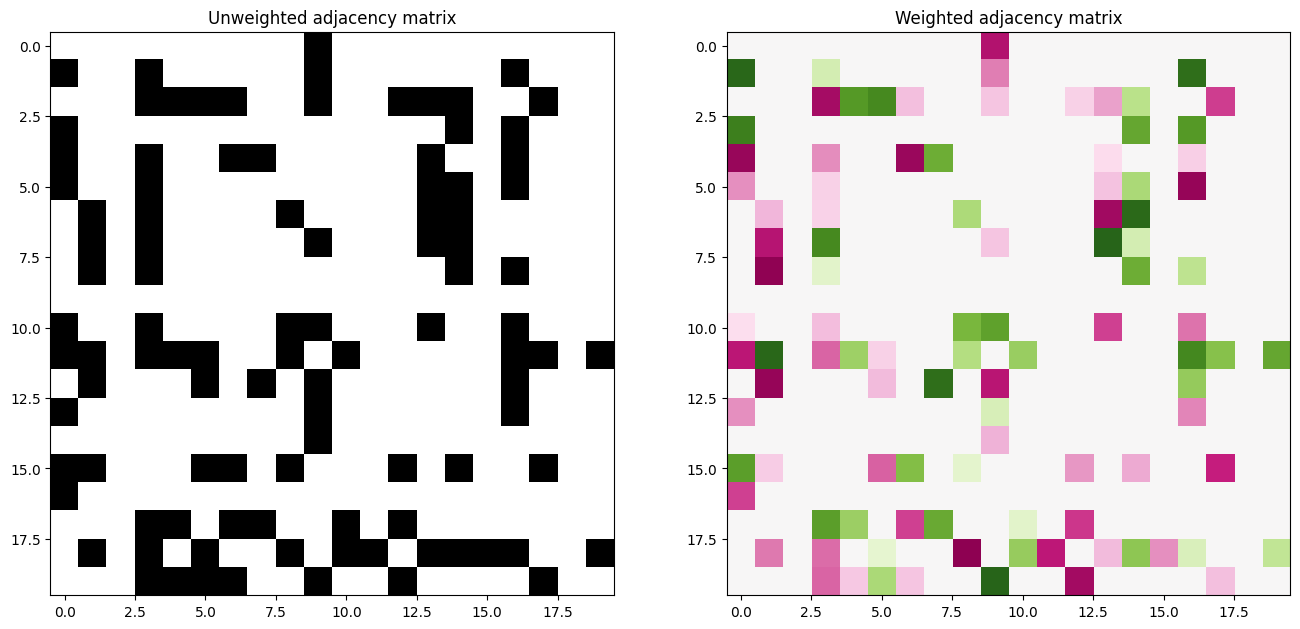

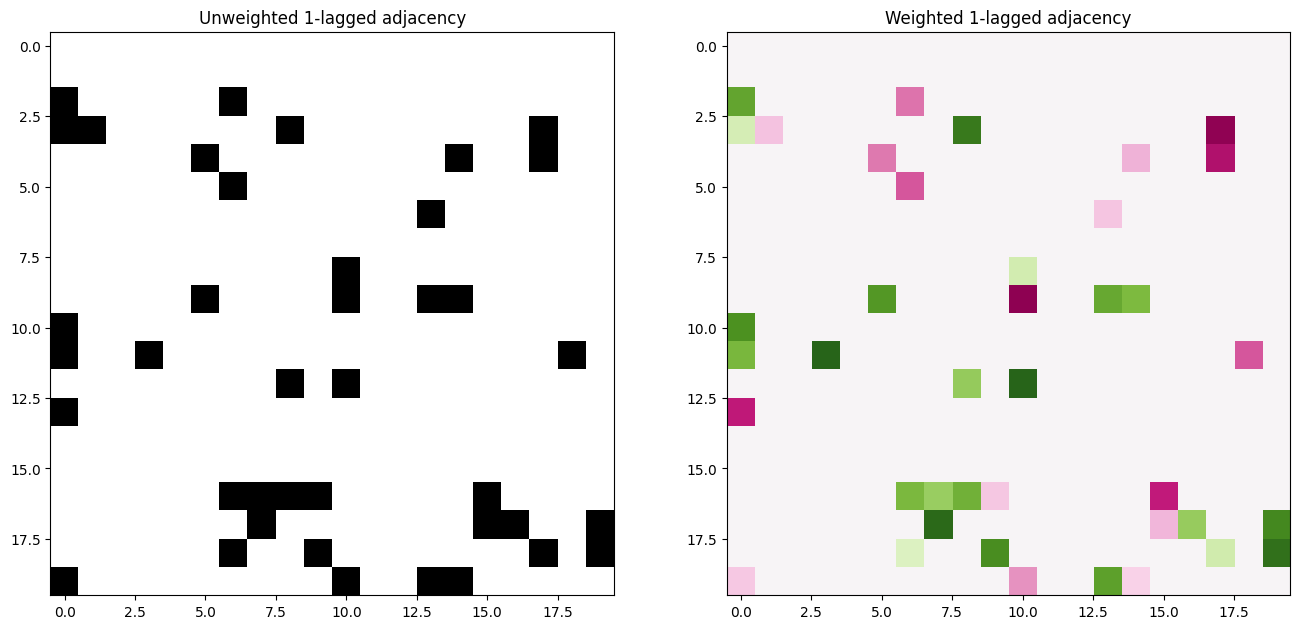

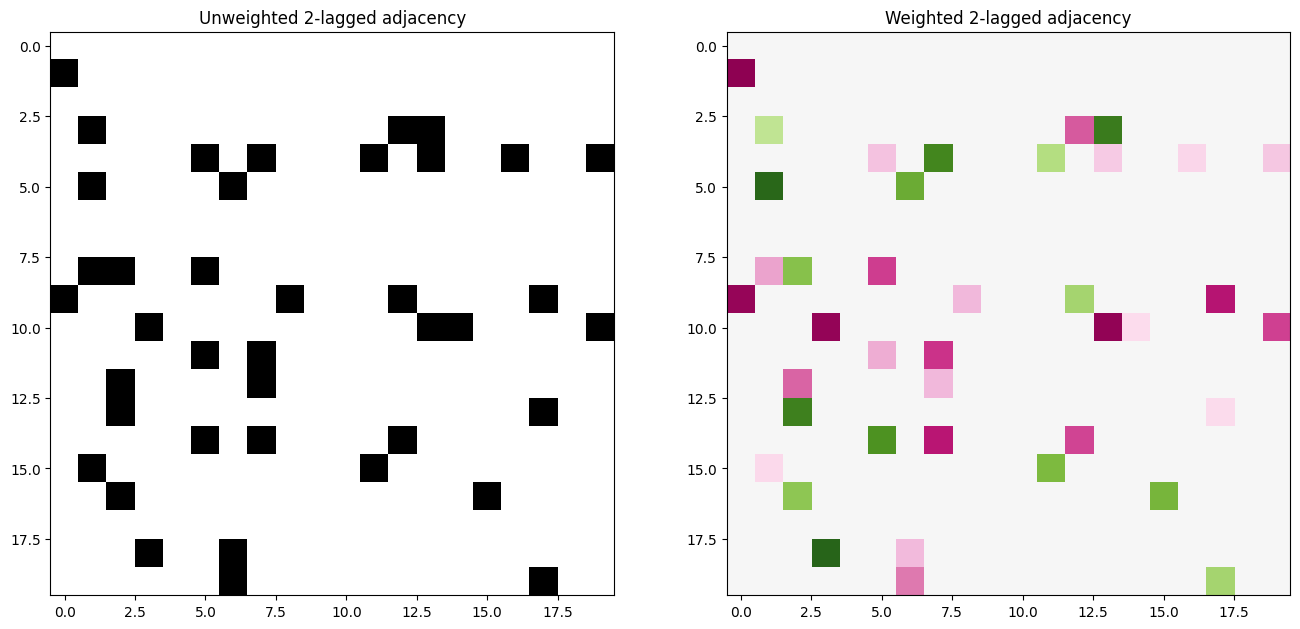

In [3]:
# Initiating the random DAG
average_degrees_per_lagged_node = [2 for _ in range(number_of_lags)]
B_true = data_generation.simulate_time_unrolled_dag(d, k * d, graph_type, number_of_lags, average_degrees_per_lagged_node) # random graph simulation with avg degree = k

# Initializing weights on the adjacency matrix
W_true = data_generation.simulate_parameter(np.array(B_true), w_ranges=((-b, -a), (a, b))) # sampling uniformly the weights
W_true = list(W_true)


for i, (B, W) in enumerate(zip(B_true, W_true)):
    # Visualizing the adjacency matrix
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 10)
    title = 'adjacency matrix' if i==0 else  '{}-lagged adjacency'.format(i)

    ax1.imshow(B, cmap='Greys') # blue = non-zero
    ax1.set_title('Unweighted {}'.format(title))

    ax2.imshow(W, cmap='PiYG') # green = positive, pink = negative
    ax2.set_title("Weighted {}".format(title))

(10, 1000, 20)


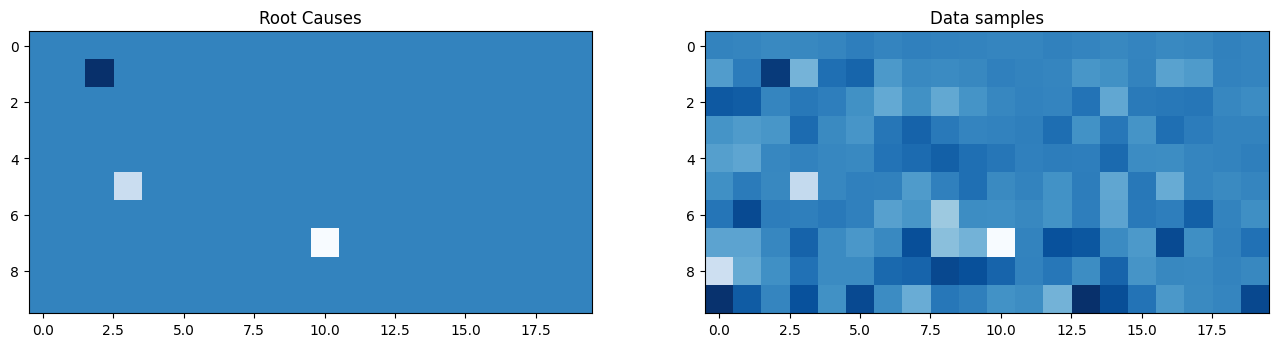

In [4]:
# X = ut.simulate_nonlinear_sem(B_true, n, sem_type, d, number_of_lags)
# Wtrue = [W_true[i * d: (i + 1) * d, -d:] for i in range(number_of_lags + 1)]
X, C_true = data_generation.sparse_input_sem(W_true, T, n=N, sparsity=sparsity, std=noise_std,
                                      noise_type=noise_type, sparsity_type=sparsity_type)
X_vis = X[0,]
C_true_vis = C_true[0,]

# Visualizing the root causes and the data 
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 10)

# Picking the first 10 samples for visualization purposes
ax1.imshow(C_true_vis[:10], cmap='Blues') # blue = non-zero
ax1.set_title('Root Causes')

ax2.imshow(X_vis[:10], cmap='Blues') # green = positive, pink = negative
ax2.set_title("Data samples")

print(X.shape)

W_true = np.concatenate(W_true, axis=1)
B_true = np.concatenate(B_true, axis=1)

## SpinSVAR execution

In [5]:
# X has shape n x t x d where 
# n: number of independent instantiations
# t: length of the time-series
# d: number of nodes  
# search_params: used for hyperparameter search, otherwise we used the best-performing hyperparameters
# ground truth: for algorithms that output edges with ambiguity we need the ground truth to allow the method get the correct result

method = "spinsvar"
params = {"lambda1" : 0.0005, "lambda2" :  0.5}

start = time.time()
W_est = spinsvar_solver(X, lambda1=params["lambda1"], lambda2=params["lambda2"], time_lag=number_of_lags, epochs=spinsvar_epochs, omega=omega, T=T)
print(" Time for spinsvar was {:.3f}".format(time.time() - start))
runtime = time.time() - start
B_est = W_est != 0


/Users/pmisiakos/Desktop/causal-learning-time-series/experiments/utils.py:339: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).reshape(n, d * T)
/Users/pmisiakos/Desktop/causal-learning-time-series/sparserc/spinsvar.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_past = torch.tensor(utils.X_past(X, self.p, device), device=device, dtype=dtype)


torch.Size([10, 1000, 60])
Epoch: 0. Regression Loss=215.796, LogDet(I-B_0)=-0.431 Sparsity=0.039, Acyclicity=0.057, Total = 108.209
Epoch: 10. Regression Loss=213.584, LogDet(I-B_0)=-0.217 Sparsity=0.037, Acyclicity=0.050, Total = 106.988
Epoch: 20. Regression Loss=211.324, LogDet(I-B_0)=-0.079 Sparsity=0.037, Acyclicity=0.045, Total = 105.783
Epoch: 30. Regression Loss=209.032, LogDet(I-B_0)=-0.016 Sparsity=0.036, Acyclicity=0.041, Total = 104.601
Epoch: 40. Regression Loss=206.773, LogDet(I-B_0)=-0.014 Sparsity=0.036, Acyclicity=0.039, Total = 103.469
Epoch: 50. Regression Loss=204.599, LogDet(I-B_0)=-0.061 Sparsity=0.036, Acyclicity=0.040, Total = 102.405
Epoch: 60. Regression Loss=202.521, LogDet(I-B_0)=-0.146 Sparsity=0.036, Acyclicity=0.042, Total = 101.412
Epoch: 70. Regression Loss=200.562, LogDet(I-B_0)=-0.263 Sparsity=0.036, Acyclicity=0.047, Total = 100.495
Epoch: 80. Regression Loss=198.750, LogDet(I-B_0)=-0.401 Sparsity=0.036, Acyclicity=0.052, Total = 99.663
Epoch: 90. R

/Users/pmisiakos/Desktop/causal-learning-time-series/experiments/utils.py:339: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).reshape(n, d * T)
/Users/pmisiakos/Desktop/causal-learning-time-series/sparserc/spinsvar.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_past = torch.tensor(utils.X_past(X, self.p, device), device=device, dtype=dtype)


## Evaluation

In [7]:
import cdt 
import sklearn.metrics
import numpy as np

# Computing the performance metrics 
nmse = np.linalg.norm(W_est - W_true) / np.linalg.norm(W_true)
shd=0
for i in range(number_of_lags + 1):
    shd += cdt.metrics.SHD(B_true[:, i * d : (i + 1) * d], B_est[:, i * d : (i + 1) * d], double_for_anticausal=False)
tpr = (B_true * B_est).sum() / B_true.sum() # tp / (tp + fn)
nnz = np.sum(B_est)
prec = sklearn.metrics.precision_score(B_true.flatten(), B_est.flatten()) # tp / (tp + fp) (1-FDR)
rec = sklearn.metrics.recall_score(B_true.flatten(), B_est.flatten()) # tp / (tp + fn)
f1 = sklearn.metrics.f1_score(B_true.flatten(), B_est.flatten()) # harmonic mean
auroc = 0# sklearn.metrics.roc_auc_score(B_true.flatten(), B_est.flatten()) # area under ROC curve

print("SparseRC performance evaluation")
print("Data on graph with {} nodes and consisting of {} samples".format(d, N))
print("Graph has {} edges".format(np.sum(B_true)))
print("\n")
print("----- Graph Metrics -------")
print("Structural Hamming Distance {:.3f}".format(shd))
print("Total edges proposed {:.3f}".format(nnz))
print("True positive rate {:.3f}".format(tpr))
print("Precision {:.3f}".format(prec))
print("Recall {:.3f}".format(rec))
print("F1-score {:.3f}".format(f1))
print("Area under ROC {:.3f}".format(auroc))
print("Normalized mean-square error on approximation of weighted adjacency {:.3f}".format(nmse))

# Evaluating the approximation of the root causes 
C_est, c_nmse, c_num, c_shd = input_approximation(method, X, T, W_est, C_true)
print("----- Root causes metrics -------")
print("Normalized mean-square error on approximation of root causes {:.3f}".format(c_nmse))
print("Number of non-zero root causes support {:.3f}".format(c_num))
print("SHD on the root causes support {:.3f}".format(c_shd))

SparseRC performance evaluation
Data on graph with 20 nodes and consisting of 10 samples
Graph has 180.0 edges


----- Graph Metrics -------
Structural Hamming Distance 0.000
Total edges proposed 180.000
True positive rate 1.000
Precision 1.000
Recall 1.000
F1-score 1.000
Area under ROC 0.000
Normalized mean-square error on approximation of weighted adjacency 0.013
----- Root causes metrics -------
Normalized mean-square error on approximation of root causes 0.088
Number of non-zero root causes support 4935.000
SHD on the root causes support 30.000


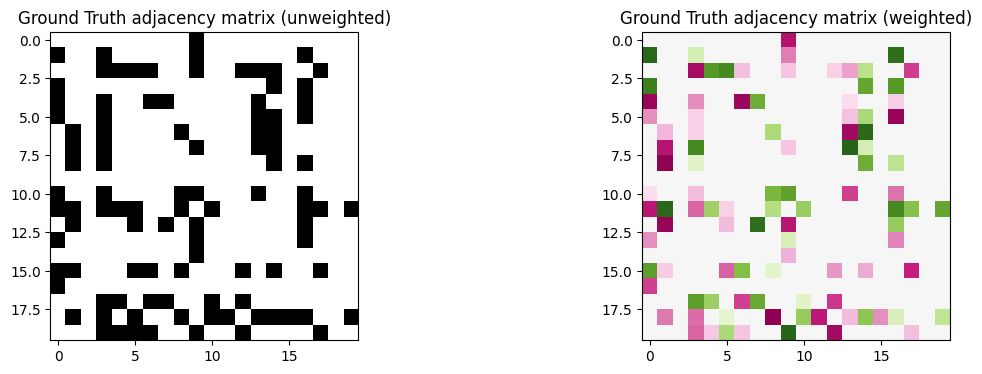

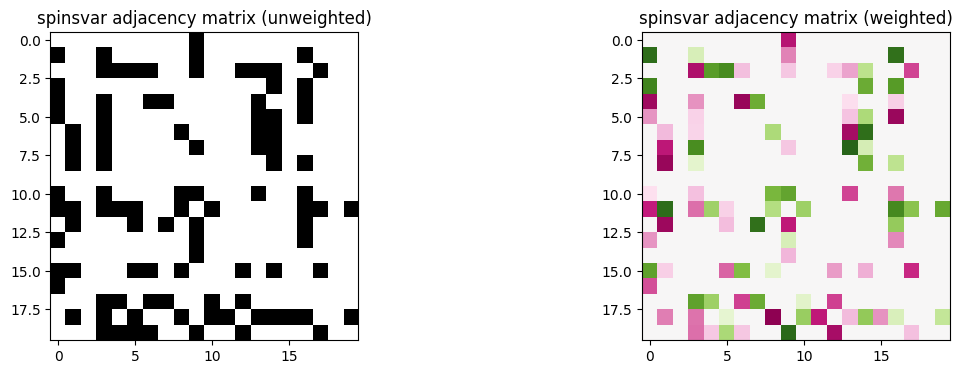

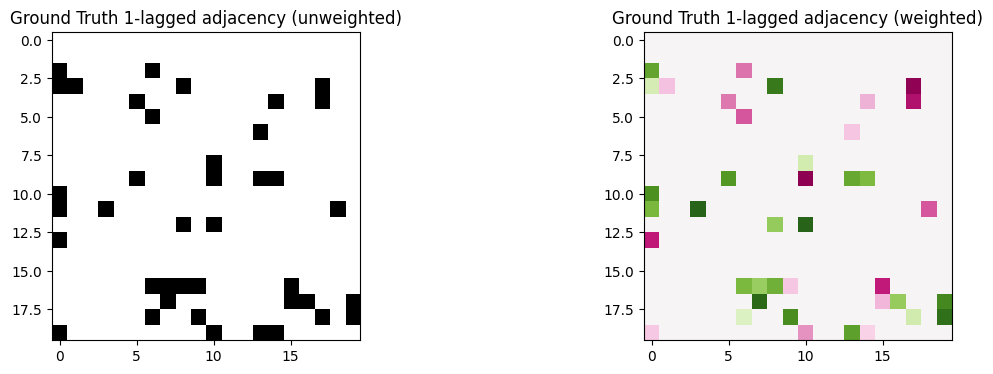

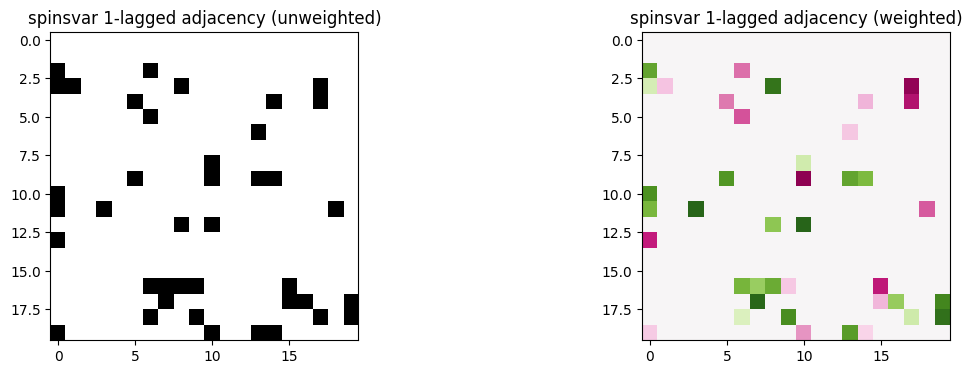

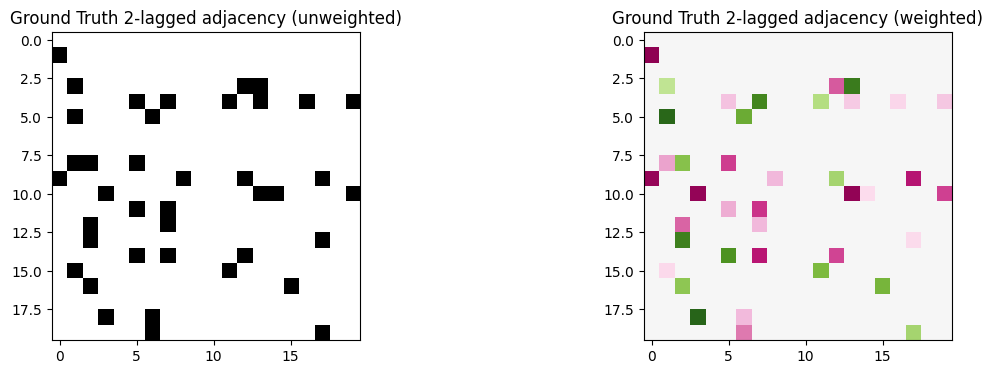

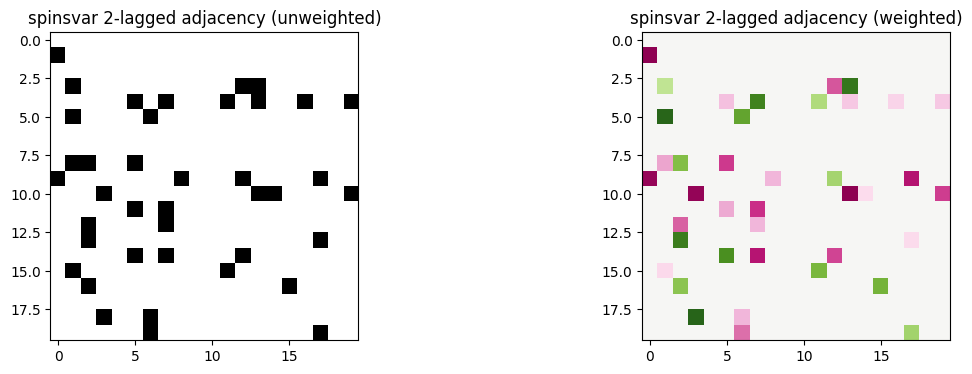

In [8]:
for i in range(p + 1):
    title = 'adjacency matrix' if i==0 else  '{}-lagged adjacency'.format(i)

    # Visualizing the original adjacency matrix
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 4)

    ax1.imshow(B_true[:, i * d : (i + 1) * d], cmap='Greys') # blue = non-zero
    ax1.set_title('Ground Truth {} (unweighted)'.format(title))

    ax2.imshow(W_true[:, i * d : (i + 1) * d], cmap='PiYG') # green = positive, pink = negative
    ax2.set_title("Ground Truth {} (weighted)".format(title))

    # Note:
    # for larger graphs the dpi imshow analysis must be set accordingly (higher).

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 4)

    ax1.imshow(B_est[:, i * d : (i + 1) * d], cmap='Greys') # blue = non-zero
    ax1.set_title('{} {} (unweighted)'.format(method, title))

    ax2.imshow(W_est[:, i * d : (i + 1) * d], cmap='PiYG') # green = positive, pink = negative
    ax2.set_title('{} {} (weighted)'.format(method, title))

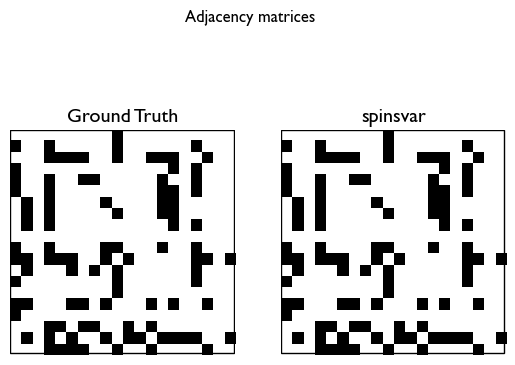

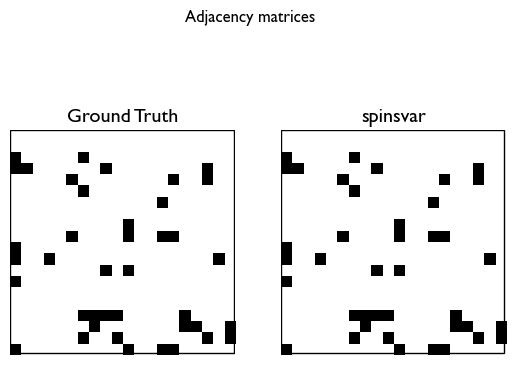

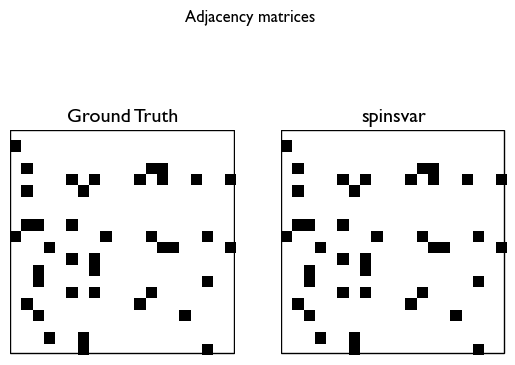

In [9]:
for i in range(p + 1):
    visualize(B_true[:, i * d : (i + 1) * d], B_est[:, i * d : (i + 1) * d], method=method, filename="visualization.png")

# Black = correct edge
# White = correctly absent edge

# Errors (if any):
# Red = wrong edge
# Grey = missing edge
